In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from tqdm.auto import tqdm

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv(r'C:\Users\loudo\ML Zoomcamp\amazon_products.csv')
categories = pd.read_csv(r'C:\Users\loudo\ML Zoomcamp\amazon_categories.csv')
data.shape

(1426337, 11)

In [3]:
data.isna().sum()

asin                 0
title                1
imgUrl               0
productURL           0
stars                0
reviews              0
price                0
listPrice            0
category_id          0
isBestSeller         0
boughtInLastMonth    0
dtype: int64

In [4]:
data = data.dropna()
data = pd.DataFrame(data)
data.dtypes

asin                  object
title                 object
imgUrl                object
productURL            object
stars                float64
reviews                int64
price                float64
listPrice            float64
category_id            int64
isBestSeller            bool
boughtInLastMonth      int64
dtype: object

In [5]:
#removing all rows with no available price
data = data[data['price'] != 0] 
data.shape

(1393564, 11)

In [6]:
# new measure discount amount, if list price is 0, no discount is available
mask = (data['listPrice']!=0)
mask_valid = [mask]

data['discount'] = 0
data.loc[mask,'discount'] = data['listPrice'] - data['price']

#new measure high-rated
data['high_rating'] = (data['stars']>=4.5)

#new measure volume of purchase
data['vol_purchase'] = data['boughtInLastMonth'] * data['price']

#new measure % discount
data['perc_discount'] = data['discount']/ data['price']

C:\Users\loudo\AppData\Local\Temp\ipykernel_30588\2233987743.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[40.   64.5  62.78 ...  1.5   3.    3.03]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask,'discount'] = data['listPrice'] - data['price']


In [7]:
#exploring product name data
pd.DataFrame(data.title.unique()).to_csv('unique_names.csv',index=False)

In [8]:
#using a list of Amazon brands, check if Name contains any of these strings
amazon_brands = ['Pinzon', 'Amazon Basics', 'AmazonBasics', 'Solimo', 'Amazon Elements','AmazonElements', 'Amazon Brand','Mama Bear','Wickedly Prime','Whole Foods','AmazonFresh','Vedaka','Goodthreads','206 Collective','Amazon Essentials','AmazonEssentials','Core 10']

pattern = '|'.join(amazon_brands)
data['amazon_owned'] = data['title'].str.contains(pattern,case=False).astype(int)

In [9]:
#quick view at values marked as owned by amazon
amazon_result = data.loc[data['amazon_owned']==1]
amazon_result.head()

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,discount,high_rating,vol_purchase,perc_discount,amazon_owned
2753,B077RTN23Y,"Men's Slim-Fit 7"" Lightweight Comfort Stretch ...",https://m.media-amazon.com/images/I/71glmyH2JR...,https://www.amazon.com/dp/B077RTN23Y,4.4,0,29.1,0.0,110,False,200,0.0,False,5820.0,0.000000,1
2820,B07DZVVBSK,"Men's Slim-Fit 5"" Flat-Front Comfort Stretch C...",https://m.media-amazon.com/images/I/71QhyifJ9a...,https://www.amazon.com/dp/B07DZVVBSK,4.3,0,29.1,0.0,110,False,200,0.0,False,5820.0,0.000000,1
3244,B07FH1B7FW,"Men's Slim-Fit 5"" Lightweight Comfort Stretch ...",https://m.media-amazon.com/images/I/71DN-naMy-...,https://www.amazon.com/dp/B07FH1B7FW,4.5,0,26.2,29.1,110,False,100,2.9,True,2620.0,0.110687,1
3491,B07BM9FCR7,Men's Long-Sleeve Slub Thermal Pullover Hoodie...,https://m.media-amazon.com/images/I/81R2X7DAk3...,https://www.amazon.com/dp/B07BM9FCR7,4.4,0,29.0,0.0,110,False,50,0.0,False,1450.0,0.000000,1
4582,B07L33NPYK,"Men's Slim-Fit 5"" Pull-on Comfort Stretch Canv...",https://m.media-amazon.com/images/I/71pmlGm1yB...,https://www.amazon.com/dp/B07L33NPYK,4.6,0,26.9,0.0,110,False,100,0.0,True,2690.0,0.000000,1


In [10]:
#aggregating down to the category level and creating important metrics
df = data.groupby(
    ['category_id']
).agg(
    item_count=('title','count'),
    amazon_owned_total=('amazon_owned', 'sum'),
    vol_purchase_total=('vol_purchase', 'sum'),
    perc_discount_mean=('perc_discount','mean'),
#    high_rating_total=('high_rating','sum'), 
    high_rating_perc=('high_rating','mean'),
#    price_median=('price','median'),
#    price_std=('price','std'),
    rating_mean=('stars','mean'),
    rating_std=('stars','std'),
    best_seller_count=('isBestSeller','sum')
).reset_index()

In [11]:
#checking variation of the outcome variable
print(sum(df.amazon_owned_total==0))
print(sum(df.amazon_owned_total>0))

114
134


In [12]:
#final dataset for analysis is produced
df['amazon_owned']=(df.amazon_owned_total>0).astype(int)
df.drop('amazon_owned_total',axis=1,inplace=True)
df

,category_id,item_count,vol_purchase_total,perc_discount_mean,high_rating_perc,rating_mean,rating_std,best_seller_count,amazon_owned
0,1,8239,15210477.5,0.052658,0.631145,4.371793,0.779219,26,0
1,2,2007,872477.5,0.047783,0.383159,3.429895,1.835233,3,1
2,3,8145,3880455.5,0.045042,0.586618,4.076194,1.352567,12,0
3,4,5506,7244766.0,0.034296,0.396840,3.404668,1.856398,11,0
4,5,5892,8775908.0,0.055485,0.683639,4.374050,0.870324,22,0
...,...,...,...,...,...,...,...,...,...
243,262,3644,2486545.0,0.065121,0.206367,1.926509,2.171204,3,0
244,263,4742,1981458.0,0.103793,0.381485,3.938823,1.261846,6,0
245,264,3175,1550107.0,0.061180,0.556220,3.365165,2.049343,35,0
246,265,266,27519.0,0.229949,0.469925,3.657895,1.699776,2,0


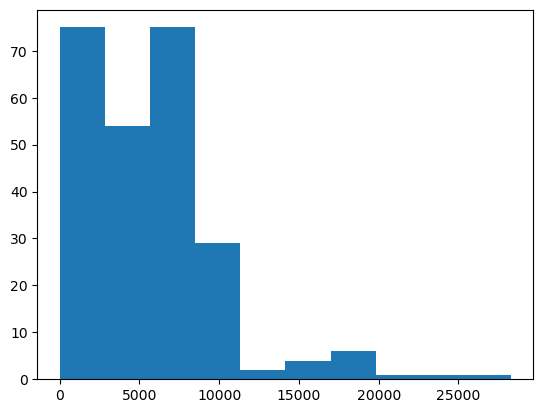

In [13]:
#EDA step 1, what do variables look like since they are all numerical
plt.hist(df.item_count)
plt.show()
#looks like greater than 10k might be interesting

In [14]:
#item count does appear predictive of amazon participation
print('% Amazon Owned with high item count: ',df[df.item_count>10000].amazon_owned.mean())
print('% Amazon Owned with low item count: ',df[df.item_count<=10000].amazon_owned.mean())

% Amazon Owned with high item count:  0.7058823529411765
% Amazon Owned with low item count:  0.5281385281385281


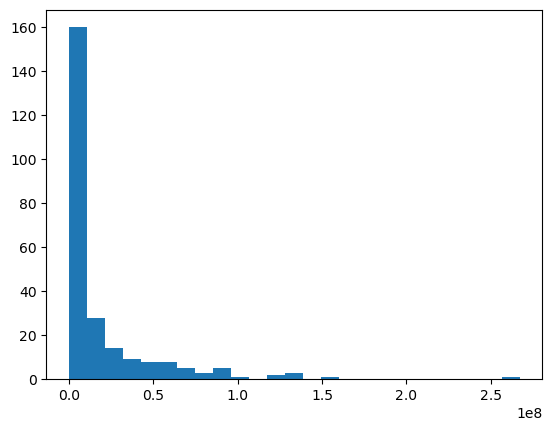

In [15]:
#EDA step 1, what do variables look like since they are all numerical
plt.hist(df.vol_purchase_total,bins=25)
#looks like greater than 1.06875835e+07 might be interesting
plt.show()

In [16]:
#item count does appear highly predictive of amazon participation
print('% Amazon Owned with high vol_purchase_total: ',df[df.vol_purchase_total>1.06875835e+07].amazon_owned.mean())
print('% Amazon Owned with low vol_purchase_total: ',df[df.vol_purchase_total<=1.06875835e+07].amazon_owned.mean())

% Amazon Owned with high vol_purchase_total:  0.8295454545454546
% Amazon Owned with low vol_purchase_total:  0.38125


In [17]:
#checking correlation with all variables
df.corrwith(df.amazon_owned).to_frame('correlation')

,correlation
category_id,-0.159475
item_count,0.378474
vol_purchase_total,0.398340
perc_discount_mean,0.033604
high_rating_perc,0.306240
rating_mean,0.320346
rating_std,-0.304627
best_seller_count,0.348621
amazon_owned,1.000000


In [18]:
#check mean diff by group
df.groupby(by='amazon_owned').mean()

,category_id,item_count,vol_purchase_total,perc_discount_mean,high_rating_perc,rating_mean,rating_std,best_seller_count
amazon_owned,,,,,,,,
0,147.184211,3801.868421,4.647499e+06,0.081775,0.420359,3.699623,1.359170,11.210526
1,122.552239,7165.305970,3.075345e+07,0.085169,0.520422,4.091162,1.042868,53.664179


In [19]:
#dropping perc_dicount_mean since it is not meaninful and setting category ID to the index because it should not be used in analysis
df.drop('perc_discount_mean',axis=1,inplace=True)
df.set_index('category_id',inplace=True)
df

,item_count,vol_purchase_total,high_rating_perc,rating_mean,rating_std,best_seller_count,amazon_owned
category_id,,,,,,,
1,8239,15210477.5,0.631145,4.371793,0.779219,26,0
2,2007,872477.5,0.383159,3.429895,1.835233,3,1
3,8145,3880455.5,0.586618,4.076194,1.352567,12,0
4,5506,7244766.0,0.396840,3.404668,1.856398,11,0
5,5892,8775908.0,0.683639,4.374050,0.870324,22,0
...,...,...,...,...,...,...,...
262,3644,2486545.0,0.206367,1.926509,2.171204,3,0
263,4742,1981458.0,0.381485,3.938823,1.261846,6,0
264,3175,1550107.0,0.556220,3.365165,2.049343,35,0


In [20]:
#splitting the data into train, test, and val making sure sizes make sense
df_full_train, df_test = train_test_split(df,test_size=.2, random_state=50)
df_train, df_val = train_test_split(df_full_train,test_size=.25, random_state=50)

print('full size: ',df.shape[0])
print('train size: ',df_train.shape[0])
print('val size: ',df_val.shape[0])
print('test size: ',df_test.shape[0])

full size:  248
train size:  148
val size:  50
test size:  50


In [21]:
#resetting indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#preserving outcome variable
y_train = (df_train.amazon_owned == 1).astype('int').values
y_val = (df_val.amazon_owned == 1).astype('int').values
y_test = (df_test.amazon_owned == 1).astype('int').values

#removing outcome variable from dfs
del df_train['amazon_owned']
del df_val['amazon_owned']
del df_test['amazon_owned']

In [22]:
df_train

,item_count,vol_purchase_total,high_rating_perc,rating_mean,rating_std,best_seller_count
0,7409,3139843.5,0.472668,3.864260,1.517878,8
1,4710,5454686.5,0.596603,4.158769,1.219255,15
2,1316,7723706.0,0.354863,3.374240,1.822349,7
3,5246,6019947.0,0.462257,4.238220,0.833700,11
4,268,6998.0,0.197761,4.239925,0.263389,4
...,...,...,...,...,...,...
143,8554,2473551.5,0.424947,3.483820,1.834839,17
144,2366,3199.0,0.194421,2.584193,2.011072,0
145,24165,6125131.0,0.624333,3.912034,1.609699,101
146,4864,267189588.0,0.749794,4.544449,0.318776,279


In [23]:
#preparing training data for vectorization and modeling
train_dict = df_train.to_dict(orient='records')
train_dict[0]

{'item_count': 7409,
 'vol_purchase_total': 3139843.5,
 'high_rating_perc': 0.4726683762990957,
 'rating_mean': 3.8642596841679038,
 'rating_std': 1.5178783346561522,
 'best_seller_count': 8}

In [24]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [25]:
X_train = dv.transform(train_dict)
X_train.shape

(148, 6)

In [26]:
dv.get_feature_names_out()

array(['best_seller_count', 'high_rating_perc', 'item_count',
       'rating_mean', 'rating_std', 'vol_purchase_total'], dtype=object)

In [27]:
#training the model
log_model = LogisticRegression(solver='liblinear',random_state=31)
log_model.fit(X_train,y_train)

LogisticRegression(random_state=31, solver='liblinear')

In [28]:
#preparing validation data and using model to predict
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
log_model.predict_proba(X_val)

array([[0.17431709, 0.82568291],
       [0.43132691, 0.56867309],
       [0.19812132, 0.80187868],
       [0.44372474, 0.55627526],
       [0.43770582, 0.56229418],
       [0.41705775, 0.58294225],
       [0.45162556, 0.54837444],
       [0.18228401, 0.81771599],
       [0.37319461, 0.62680539],
       [0.20276441, 0.79723559],
       [0.47784933, 0.52215067],
       [0.13579442, 0.86420558],
       [0.48494632, 0.51505368],
       [0.3478039 , 0.6521961 ],
       [0.4618566 , 0.5381434 ],
       [0.18458123, 0.81541877],
       [0.44085125, 0.55914875],
       [0.09042916, 0.90957084],
       [0.4598724 , 0.5401276 ],
       [0.49973482, 0.50026518],
       [0.43543503, 0.56456497],
       [0.02704642, 0.97295358],
       [0.01926751, 0.98073249],
       [0.08933829, 0.91066171],
       [0.4945348 , 0.5054652 ],
       [0.4883566 , 0.5116434 ],
       [0.24462679, 0.75537321],
       [0.18764702, 0.81235298],
       [0.47495751, 0.52504249],
       [0.46702491, 0.53297509],
       [0.

In [29]:
y_pred = log_model.predict_proba(X_val)[:,1]
y_pred

array([0.82568291, 0.56867309, 0.80187868, 0.55627526, 0.56229418,
       0.58294225, 0.54837444, 0.81771599, 0.62680539, 0.79723559,
       0.52215067, 0.86420558, 0.51505368, 0.6521961 , 0.5381434 ,
       0.81541877, 0.55914875, 0.90957084, 0.5401276 , 0.50026518,
       0.56456497, 0.97295358, 0.98073249, 0.91066171, 0.5054652 ,
       0.5116434 , 0.75537321, 0.81235298, 0.52504249, 0.53297509,
       0.50012709, 0.51017553, 0.6507964 , 0.77163518, 0.9698201 ,
       0.54506261, 0.60186388, 0.51514428, 0.50667019, 0.506972  ,
       0.99497732, 0.57254451, 0.9259417 , 0.50104573, 0.51971747,
       0.66107778, 0.62818933, 0.51440863, 0.50337273, 0.51621411])

In [30]:
#accuracy with default of .5 doesn't look great, need to improve with tuning
amazon_enter = (y_pred >= .5)
(y_val == amazon_enter).mean()

0.54

In [31]:
thresholds = np.linspace(.5, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.50 0.540
0.53 0.760
0.55 0.760
0.57 0.760
0.60 0.780
0.62 0.760
0.65 0.760
0.68 0.780
0.70 0.780
0.72 0.780
0.75 0.780
0.78 0.740
0.80 0.720
0.82 0.640
0.85 0.620
0.88 0.600
0.90 0.600
0.93 0.560
0.95 0.540
0.98 0.500
1.00 0.460


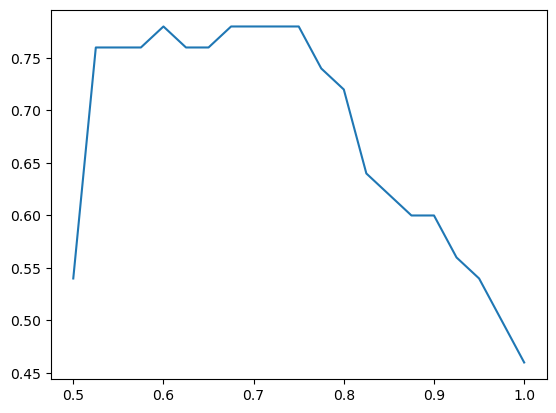

In [32]:
#.7 is best threshhold for accuracy
plt.plot(thresholds, scores)
plt.show()

In [33]:
#calculating precision and recall
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = .7
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

p = tp / (tp + fp)
print('Precision: ',p)

r = tp / (tp + fn)
print('Recall: ',r)

Precision:  1.0
Recall:  0.5925925925925926


In [34]:
#calculating TPR and FRP
tpr = tp / (tp + fn)
print('TPR: ',tpr)

fpr = fp / (fp + tn)
print('FPR: ',fpr)

TPR:  0.5925925925925926
FPR:  0.0


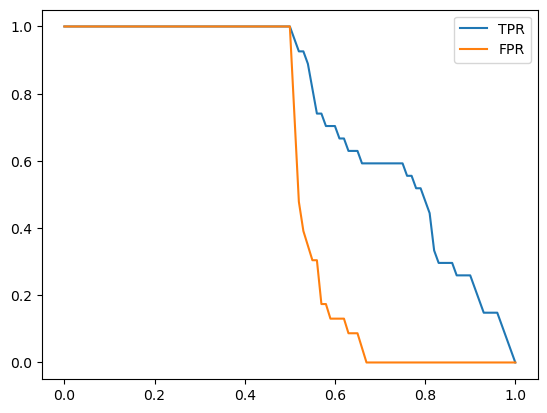

In [35]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()
plt.show()

In [36]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

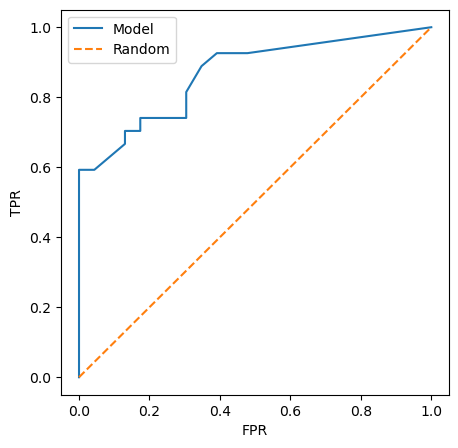

In [37]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

In [38]:
auc(fpr, tpr)

0.8743961352657005

In [39]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [40]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [41]:
n_splits = 4

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.amazon_owned.values
        y_val = df_val.amazon_owned.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.790 +- 0.013
C=0.01 0.870 +- 0.029
C=0.1 0.923 +- 0.052
C=0.5 0.969 +- 0.046
C=1 0.895 +- 0.062
C=5 0.966 +- 0.058
C=10 0.966 +- 0.058


In [42]:
scores

[1.0, 1.0, 0.8656462585034014, 1.0]

In [43]:
dv, log_model = train(df_full_train, df_full_train.amazon_owned.values, C=.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.801470588235294

In [44]:
#deleting amazon_owned from df again before xgboost and converting train df to dict
del df_train['amazon_owned']
del df_val['amazon_owned']

In [45]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [46]:
#lets try out an XGboost decision tree instead to see how it handles it
dv = DictVectorizer(sparse=False) 
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [47]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [48]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [49]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [50]:
s = output.stdout
print(s[:200])

[0]	train-auc:0.86626	val-auc:0.82997
[5]	train-auc:0.93592	val-auc:0.84091
[10]	train-auc:0.95665	val-auc:0.82828
[15]	train-auc:0.97468	val-auc:0.80808
[20]	train-auc:0.98297	val-auc:0.81987
[25]	tr


In [51]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [52]:
df_score = parse_xgb_output(output)

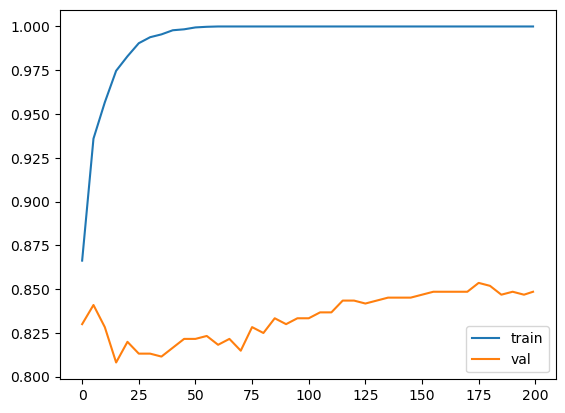

In [53]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

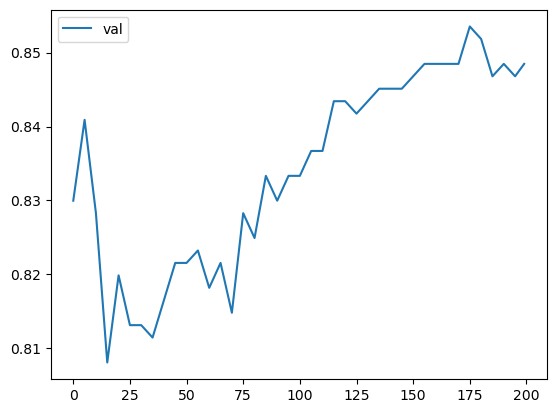

In [54]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

In [55]:
scores = {}

In [56]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [57]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

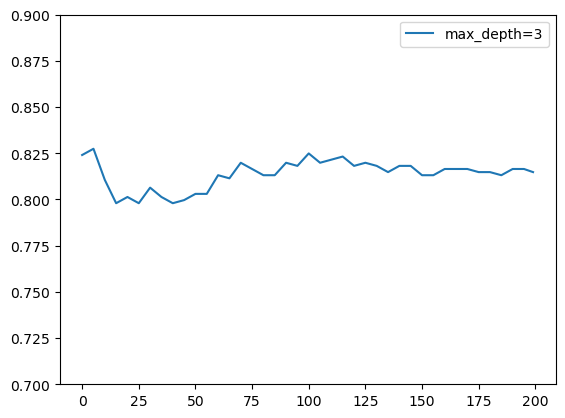

In [58]:
#max depth=2 is definitely the best option here around num rounds 75
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(.7, .9)
plt.legend()
plt.show()

In [59]:
scores = {}

In [60]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [61]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.5'

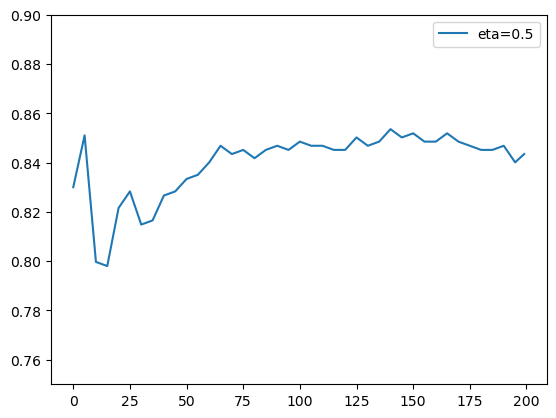

In [62]:
#eta of .5 is the best
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.ylim(0.75, .9)
plt.legend()
plt.show()

In [63]:
scores = {}

In [64]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [65]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

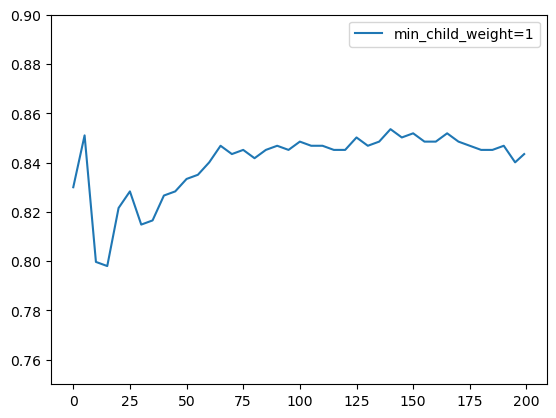

In [66]:
#min child weight of 1 is best
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.75, 0.9)
plt.legend()
plt.show()

In [67]:
#final xgboost model
xgb_params = {
    'eta': 0.5, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [68]:
y_pred = xgb_model.predict(dval)
roc_auc_score(y_val,y_pred)

0.8501683501683501

In [69]:
#this auc score is higher than the regression, so we will use this model on full dataset
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.amazon_owned.values
del df_full_train['amazon_owned']

In [70]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [71]:
dv.get_feature_names_out().tolist()

['best_seller_count',
 'high_rating_perc',
 'item_count',
 'rating_mean',
 'rating_std',
 'vol_purchase_total']

In [72]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [73]:
xgb_params = {
    'eta': 0.5, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

final_xgb_model = xgb.train(xgb_params, dfulltrain, num_boost_round=100)

In [74]:
y_pred = final_xgb_model.predict(dtest)

In [75]:
roc_auc_score(y_test, y_pred)

0.7775735294117647

In [76]:
#final ROC AUC score is lower than that on the test. This is unfortunate, but likely a result of the limitations of sample size with this particular dataset. I think this is the best we can do given the circumstances

In [80]:
y_pred

array([8.0453211e-01, 9.9262953e-01, 8.8474032e-04, 9.8905724e-01,
       9.8962420e-01, 9.9564219e-01, 6.5302485e-01, 8.3388591e-01,
       9.7137064e-01, 2.8779129e-03, 2.4102664e-02, 4.5785311e-01,
       9.9322456e-01, 8.3784801e-01, 2.3770016e-01, 9.3798792e-01,
       8.2255438e-02, 2.5556365e-02, 1.0225121e-01, 9.8067665e-01,
       1.0782029e-03, 5.1064229e-01, 9.6519543e-03, 9.8971736e-01,
       9.7091573e-01, 9.9617565e-01, 1.7444985e-02, 8.3122665e-01,
       3.1861526e-04, 8.0375880e-01, 2.1692429e-01, 8.5184115e-01,
       6.5683889e-01, 3.8985810e-01, 9.9663061e-01, 3.5613164e-02,
       9.9088180e-01, 9.9388027e-01, 6.0731541e-02, 1.0973148e-02,
       7.0719582e-01, 4.2752679e-02, 8.7484020e-01, 9.0536588e-01,
       3.3340134e-02, 7.9124224e-01, 9.0301466e-01, 8.6401522e-01,
       2.5556365e-02, 3.0634657e-02], dtype=float32)